# Part 1: Data Profiling, Transformation, and Visualization

Part 1: Data Profiling, Transformation, and Visualization lays the foundation for regression modeling in Part 2. This notebook analyzes CO2 emissions from 7,385 Canadian vehicles to predict pollution using regression, starting with data cleaning and exploratory data analysis. The second part of the portfolio will deal with a regression problem with the analyzed dataset in this notebook.

- Debajyoti Podder (2020). Dataset: CO2 Emission by Vehicles - Amount of CO2 emissions by a vehicle depending on their various features. URL: [https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles](https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles)

In [ ]:
# Kagglehub is used to directly download the data file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [ ]:
# Given a Pandas series, returns the absolute and relative frequencies
def get_freq_table(values_series):
  freq_table=pd.DataFrame({"Abs. frequency": values_series.value_counts(),
                           "Rel. frequency": 100*values_series.value_counts(normalize=True)})
  return(freq_table.T.round(decimals=1))

# Given a Pandas DF, returns the a barchart of the top 20 values
def ordered_barchart_topvals(values_df, variable_name):
  large_to_small = values_df.groupby(variable_name).size().sort_values()
  large_to_small = large_to_small.iloc[20:].index[::-1] if len(large_to_small)>20 else large_to_small.index[::-1]
  fig=plt.figure(figsize=(10, 5))
  fig.suptitle("Barchart: "+variable_name, x=0.15, fontsize = "xx-large")
  sns.countplot(data = values_df, y = variable_name, order = large_to_small)

# Definition of an auxiliary function to label the sectors in the pie chart
def autopct_format(values):
  def val_per_format(pct):
    total = sum(values)
    val = int(round(pct*total/100.0))
    return '{:.1f}%\n({v:d})'.format(pct, v=val)
  return val_per_format

The following cell loads the dataset as a DataFrame, consisting of 7,385 rows and 12 columns.

In [ ]:
datapath = kagglehub.dataset_download("debajyotipodder/co2-emission-by-vehicles", path='CO2 Emissions_Canada.csv')
df_raw = pd.read_csv(datapath, header=0, sep=',', quotechar='"')
df_raw

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
...,...,...,...,...,...,...,...,...,...,...,...,...
7380,VOLVO,XC40 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
7381,VOLVO,XC60 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,11.2,8.3,9.9,29,232
7382,VOLVO,XC60 T6 AWD,SUV - SMALL,2.0,4,AS8,Z,11.7,8.6,10.3,27,240
7383,VOLVO,XC90 T5 AWD,SUV - STANDARD,2.0,4,AS8,Z,11.2,8.3,9.9,29,232


The variables have the following types and contain the detailed information below:

- **Continuous Numerical Variables**
  - `Engine Size(L)`: Engine size in liters.
  - `Fuel Consumption City (L/100 km)`: Average city fuel consumption in liters per 100 kilometers.
  - `Fuel Consumption Hwy (L/100 km)`: Average highway fuel consumption in liters per 100 kilometers.
  - `Fuel Consumption Comb (L/100 km)`: Weighted average of fuel consumption (55% city, 45% highway).
  - `Fuel Consumption Comb (mpg)`: Unit conversion of the previous variable to miles per gallon.
  - `CO2 Emissions(g/km)`: Combined CO2 emissions (city and highway) in grams per kilometer.
  
- **Discrete Numerical Variables**. `Cylinders`: Number of cylinders in the car.

- **Ordinal Numerical Variables**: None.

- **Nominal Categorical Variables**:
  - `Make` and `Model`: Manufacturer and model of the vehicle. Together, these variables identify each row.
  - `Vehicle Class`: Nominal categorical variable indicating the type of car (SUV, compact, van, etc.).
  - `Fuel Type`: Fuel type: X = gasoline, Z = premium gasoline, D = diesel, E = ethanol (E85), N = natural gas.


The `Transmission` variable deserves special mention, as it is a composite column where the first alphabetic characters indicate the type of transmission (automatic or manual), and the second half, numeric characters, indicate the number of gears (this can be verified by running the following cell, which shows the 20 most frequent values in the `Transmission` variable). The abbreviations correspond as follows: A = Automatic, AM = Automated Manual, AS = Automatic with Selective Shift, AV = Continuously Variable, M = Manual.



In [ ]:
df_raw["Transmission"].value_counts().head()

,count
Transmission,
AS6,1324
AS8,1211
M6,901
A6,789
A8,490


## Data Preparation (First Iteration)
We will separate the `Transmission` column, which contains both the car’s transmission type (manual, automatic, etc.) and the number of gears, into two different variables: `Gears` (discrete numerical) and `Transmission` (nominal categorical). Generally, `Gears` will be the last character of the original column, and `Transmission` will be all the remaining characters.




In [ ]:
gears = df_raw["Transmission"].str[-1]
transmission = df_raw["Transmission"].str[:-1]

# We need to correct the values for the AV category and cars with 10 gears (A10, AV10, AS10).
transmission[gears == "0"] = transmission[gears == "0"].str[:-1] # Remove extra 1s
transmission[gears == "V"] = transmission[gears == "V"] + "V" # Add a V
gears[gears == "0"] = 10
gears[gears == "V"] = 0

# Finally, we introduce the calculated values into the DataFrame, adding Gears as a numerical variable.
df_raw["Gears"] = gears.astype(int)
df_raw["Transmission"] = transmission

## Data Understanding: Descriptive Statistics


After the initial preprocessing, we proceed to the analysis of the variables in the dataset. In this process, it is essential to consider the type of variables.We will begin with a univariate study of the variables, followed by a bivariate study where we will examine the relationships between them, especially with respect to the response variable considered in the second part of the portfolio (`CO2 Emissions(g/km)`).

In the following cell, various sets are defined: in the first part, variables are grouped according to their type, while in the second, the colors used in the charts created in this section are defined.



In [ ]:
# Sets of variables
response_variable = "CO2 Emissions(g/km)"
numeric_variables = ["Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)",
                     "Fuel Consumption Comb (L/100 km)", "Fuel Consumption Comb (mpg)",
                     "Engine Size(L)", "Cylinders", "Gears"]
categoric_variables = ["Transmission", "Vehicle Class", "Fuel Type", "Make", "Model"]

# Color sets for the charts
num_color_palette = sns.color_palette()
cat_color_palette = sns.color_palette("husl")
cor_color_palette = sns.diverging_palette(240, 10, as_cmap=True)

### Univariate: Numerical Variables
The `CO2 Emissions(g/km)` variable has a fairly symmetric distribution (mean and median are close) with no missing values (`count` row). The third quartile is half the maximum value of the variable, implying that there are one or more observations with values much higher than the rest. The graphical study of the variable is another way to draw the previous conclusions.

In [ ]:
df_raw[response_variable].describe()

,CO2 Emissions(g/km)
count,7385.000000
mean,250.584699
std,58.512679
min,96.000000
25%,208.000000
50%,246.000000
75%,288.000000
max,522.000000


<Axes: ylabel='CO2 Emissions(g/km)'>

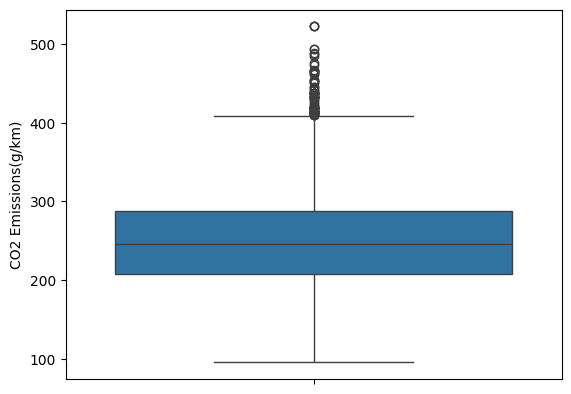

In [ ]:
sns.boxplot(data = df_raw, y = response_variable, color = num_color_palette[0])

Outliers above 500 g/km suggest high-pollution vehicles. Specifically, a Bugatti car is included 3 times in the dataset. There are duplicated rows in the dataset. We will address this after completing the exploratory data analysis.



In [ ]:
max_pollution = df_raw[response_variable]==max(df_raw[response_variable])
df_raw.loc[max_pollution,:]

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km),Gears
4509,BUGATTI,CHIRON,TWO-SEATER,8.0,16,AM,Z,26.8,16.6,22.2,13,522,7
5575,BUGATTI,Chiron,TWO-SEATER,8.0,16,AM,Z,26.8,16.6,22.2,13,522,7
6640,BUGATTI,Chiron,TWO-SEATER,8.0,16,AM,Z,26.8,16.6,22.2,13,522,7


Now it’s time to conduct the descriptive study of the numerical predictors or features. In the following cell, to study their statistics, whereas the one after contains a graphical study of the numerical variables using box plots:

- The scales of the variables are very different, implying the need to normalize the variables before using any ML model. The variables seem fairly symmetric, as the means are close to the medians. Additionally, there are no missing values. The `Cylinders` variable, being discrete, has the same value for the median and the third quartile.

- The consumption variables have similar distributions due to the relationship between them. This is evidence in favor of removing the combined variables later. Outliers are values above the upper whisker of the box. In the case of `Gears`, the outliers are automatic cars that we encoded with the value 0 (295 observations).

In [ ]:
df_raw[numeric_variables].describe()

,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),Engine Size(L),Cylinders,Gears
count,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000
mean,12.556534,9.041706,10.975071,27.481652,3.160068,5.615030,6.611510
std,3.500274,2.224456,2.892506,7.231879,1.354170,1.828307,1.795264
min,4.200000,4.000000,4.100000,11.000000,0.900000,3.000000,0.000000
25%,10.100000,7.500000,8.900000,22.000000,2.000000,4.000000,6.000000
50%,12.100000,8.700000,10.600000,27.000000,3.000000,6.000000,6.000000
75%,14.600000,10.200000,12.600000,32.000000,3.700000,6.000000,8.000000
max,30.600000,20.600000,26.100000,69.000000,8.400000,16.000000,10.000000


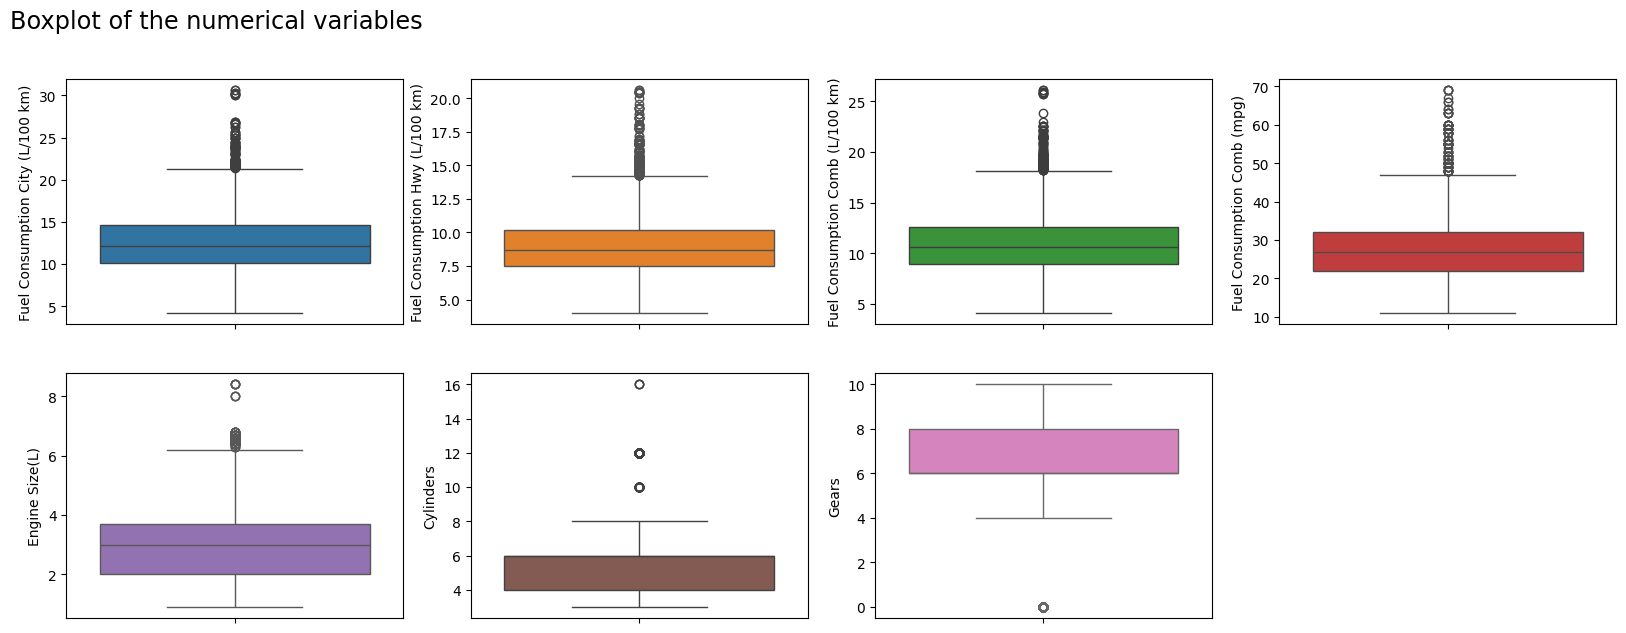

In [ ]:
fig = plt.figure(figsize=(20, 7))
fig.suptitle("Boxplot of the numerical variables", x=0.2, fontsize = "xx-large")
for i in range(0,7):
    plt.subplot(2, 4, i+1)
    sns.boxplot(data=df_raw, y=numeric_variables[i], color = num_color_palette[i])

###  Univariate: Categorical Variables
- There are no missing values in the variables (as `count` equals to the total number of rows). The `top` row shows the mode of each variable (most frequent category), and `freq` shows the absolute frequency associated with these categories.
- The relatively large amount of categories in `Make` and `Vehicle Class` according to the number of observation, 16 and 42 respectively, make us doubt its usefulness in a Regression model. The `Model` variable has is an identifying value.
- The barcharts in this section limit the displayed items to the top 20 values.

In [ ]:
df_raw[categoric_variables].describe()

,Transmission,Vehicle Class,Fuel Type,Make,Model
count,7385,7385,7385,7385,7385
unique,5,16,5,42,2053
top,AS,SUV - SMALL,X,FORD,F-150 FFV
freq,3127,1217,3637,628,32


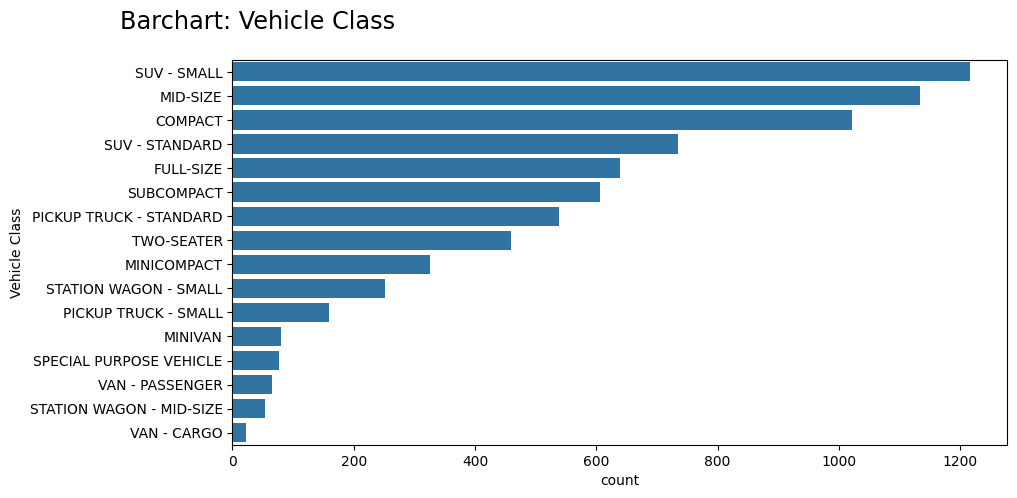

In [ ]:
ordered_barchart_topvals(df_raw, categoric_variables[1])

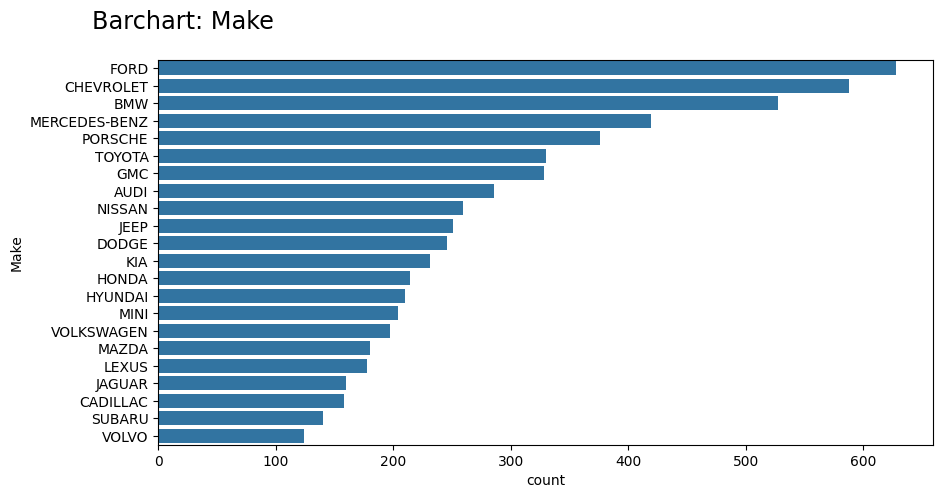

In [ ]:
ordered_barchart_topvals(df_raw, categoric_variables[3])

- The following cells will describe in more detail `Transmission` and `Fuel Type` variables and their 5 categories, using the absolute and relative frequencies of their categories, as well as using pie charts. `Fuel Type` has two categories with low representation; only one vehicle uses natural gas as fuel. Later, we won't use this observation to train the ML models as its behavior is quite different from the rest of the vehicles.

In [ ]:
get_freq_table(df_raw[categoric_variables[2]])

Fuel Type,X,Z,E,D,N
Abs. frequency,3637.0,3202.0,370.0,175.0,1.0
Rel. frequency,49.2,43.4,5.0,2.4,0.0


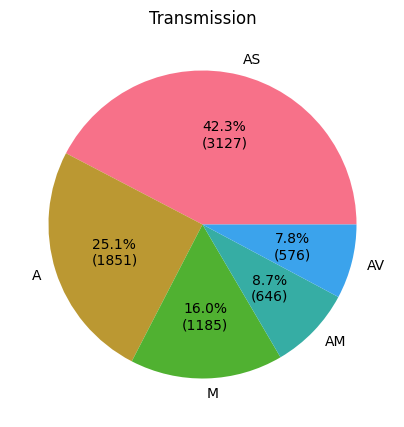

In [ ]:
fig=plt.figure(figsize=(5, 5))
rel_frequencies = df_raw[categoric_variables[0]].value_counts()
rel_frequencies.plot.pie(colors=cat_color_palette, labels=rel_frequencies.index,
                         autopct=autopct_format(rel_frequencies),
                         title="Transmission", ylabel="");

- The `Vehicle Class` variable has 8 categories with a relative frequency below 5%. This may make the variable unhelpful in ML models or even detrimental to their goodness of fit by introducing noise. The following table shows the top 10 categories of the variable.



In [ ]:
freq_table=pd.DataFrame({"Frec. absolutas": df_raw[categoric_variables[1]].value_counts(),
                    "Frec. relativas": 100*df_raw[categoric_variables[1]].value_counts(normalize=True)})
freq_table.sort_values("Frec. absolutas", ascending=False).iloc[0:9,].T.round(decimals=1)

Vehicle Class,SUV - SMALL,MID-SIZE,COMPACT,SUV - STANDARD,FULL-SIZE,SUBCOMPACT,PICKUP TRUCK - STANDARD,TWO-SEATER,MINICOMPACT
Frec. absolutas,1217.0,1133.0,1022.0,735.0,639.0,606.0,538.0,460.0,326.0
Frec. relativas,16.5,15.3,13.8,10.0,8.7,8.2,7.3,6.2,4.4


### Bivariate: Response Variable + Categorical Variables

Bivariate descriptive statistics aim to study the relationship between pairs of variables. Once again, it will be crucial to consider the types of variables involved. In ML workflows, it is relevant to focus on the relationship between the response variable and the rest of the variables (which will end up being predictors in the model).

- `Transmission` variable: The pollution difference between cars with continuously variable transmission and other types of vehicles is significant, with the former having the lowest consumption. Excluding these, the remaining automatic transmissions pollute more on average than manual ones. The conclusions are similar if we compare median values. Fuel consumption in cars with automated manual transmission (AM) seems more variable, as indicated by the standard deviation and quartiles.

In [ ]:
df_raw.groupby(categoric_variables[0])[response_variable].describe()

,count,mean,std,min,25%,50%,75%,max
Transmission,,,,,,,,
A,1851.0,277.621826,51.964246,162.0,240.0,276.0,310.0,488.0
AM,646.0,249.727554,70.160790,96.0,205.0,239.0,282.0,522.0
AS,3127.0,255.392709,52.590639,124.0,216.0,249.0,288.0,476.0
AV,576.0,184.310764,37.497719,104.0,162.0,184.5,207.0,271.0
M,1185.0,228.345992,51.285388,147.0,187.0,216.0,257.0,450.0


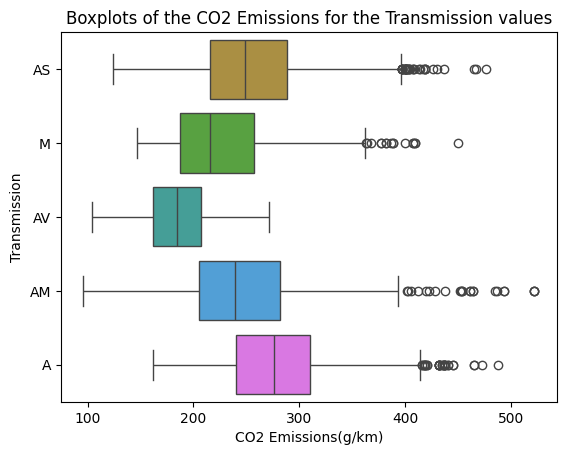

In [ ]:
sns.boxplot(data=df_raw, x=response_variable, y=categoric_variables[0],
            hue=categoric_variables[0], palette=cat_color_palette[1:],
            legend=False).set_title("Boxplots of the CO2 Emissions for the Transmission values")
plt.show()

- `Vehicle Class` variable: The high number of categories in the categorical variable makes it difficult to make assessments using statistical tables. Pollution generated by vans is higher compared to other vehicle types. Pollution from two-seater cars seems variable: the distribution has high variability. With the multiple box plot, we can visualize the difference of this subtype compared to the rest. It appears that smaller cars pollute the least.

In [ ]:
df_raw.groupby(categoric_variables[1])[response_variable].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
Vehicle Class,,,,,,,,
STATION WAGON - SMALL,252.0,200.067460,33.410274,110.0,185.50,198.0,217.00,382.0
COMPACT,1022.0,216.679061,50.443913,106.0,182.00,206.5,239.00,404.0
MID-SIZE,1133.0,222.455428,55.602443,104.0,184.00,214.0,253.00,465.0
SUV - SMALL,1217.0,236.292523,31.217718,128.0,214.00,233.0,257.00,353.0
MINICOMPACT,326.0,236.607362,40.971650,143.0,202.00,242.0,258.75,365.0
SPECIAL PURPOSE VEHICLE,77.0,237.597403,21.961845,208.0,219.00,234.0,248.00,298.0
STATION WAGON - MID-SIZE,53.0,238.698113,56.414532,126.0,216.00,230.0,253.00,386.0
SUBCOMPACT,606.0,246.448845,49.772772,152.0,210.00,239.0,280.00,392.0
MINIVAN,80.0,262.312500,17.744740,221.0,250.75,265.5,275.00,296.0


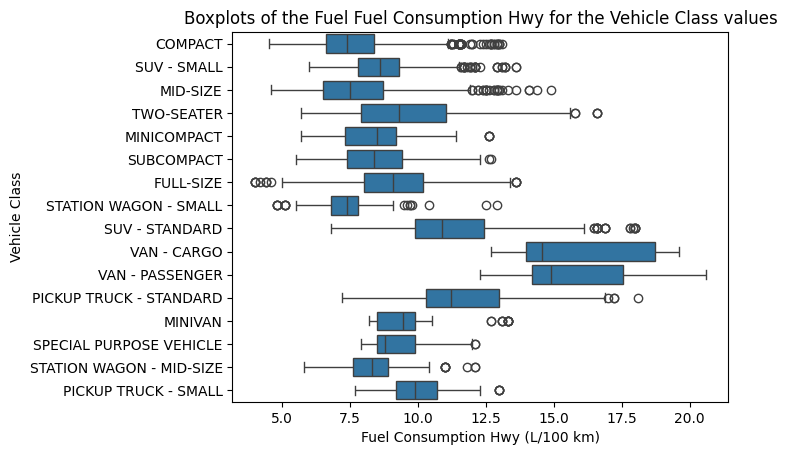

In [ ]:
sns.boxplot(data=df_raw, x=numeric_variables[1], y=categoric_variables[1]).set_title(
    "Boxplots of the Fuel Fuel Consumption Hwy for the Vehicle Class values")
plt.show()

- ``Fuel Type`` variable: Vehicles using ethanol pollute more on average. Although, on average and median, gasoline and diesel vehicles seem to pollute about the same, there are certain gasoline cars that pollute significantly more.
Similarly, these conclusions can be obtained graphically.

In [ ]:
df_raw.groupby(categoric_variables[2])[response_variable].describe()

,count,mean,std,min,25%,50%,75%,max
Fuel Type,,,,,,,,
D,175.0,237.548571,41.817704,169.0,198.0,245.0,271.0,326.0
E,370.0,275.091892,47.093198,128.0,248.0,279.0,299.0,418.0
N,1.0,213.000000,NaN,213.0,213.0,213.0,213.0,213.0
X,3637.0,235.119329,57.401473,96.0,192.0,228.0,274.0,488.0
Z,3202.0,266.043410,56.695972,122.0,225.0,255.0,301.0,522.0


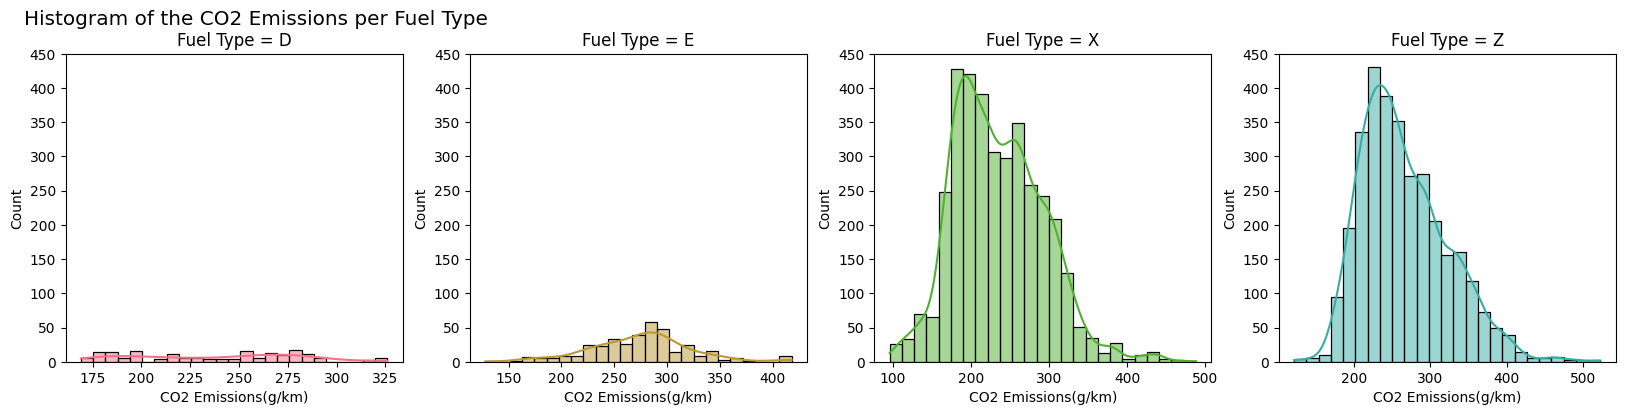

In [ ]:
fig=plt.figure(figsize=(20, 4))
fig.suptitle("Histogram of the CO2 Emissions per Fuel Type", x=0.22, y=0.99, fontsize = "x-large")
categoric_values = ["D", "E", "X", "Z"]

for i in range(0,4):
    plt.subplot(1, 4, i+1)
    data_subset = df_raw.loc[df_raw[categoric_variables[2]]==categoric_values[i],]

    sns.histplot(data=data_subset, x=response_variable, bins = 25, color=cat_color_palette[i], kde=True)
    plt.title("Fuel Type = "+categoric_values[i])
    plt.ylim(0, 450)

### Bivariate: Numerical Variables

The relationship between two numerical variables is studied using the correlation coefficient, covariance, and scatter plots, among others. When studying the interaction between numerical variables in ML workflows, the focus is usually on two sets of variables:

- Response variable vs. numerical (predictor) variables: This indicates which predictors may be more related to the response variable. Generally, these variables will be more useful in models for making predictions.

- Set of numerical (predictor) variables: In this case, it is also relevant to study the relationship between these variables. ML models, especially linear ones, assume the independence of predictor variables as a starting point. When this is not met, multicollinearity issues can arise, where, for example, the variability of predictions is very high. As an intuitive idea, consider that models exhibit undesirable behavior if redundant information is introduced. Including two variables with a high correlation coefficient in a model is roughly equivalent to entering the same information twice on different scales. In the best case, the model will ignore one of the variables, while in most cases, it will introduce noise and be detrimental to predictions.

We will start by studying the scatter plots between the response variable (pollution) and the predictors.

- It seems that the relationship between the first three consumption variables and emitted pollution is increasing: as they increase, the car pollutes more. The combined fuel consumption in miles per gallon is inversely proportional to CO2 emissions and appears to have a non-linear relationship.
- The larger the car’s engine (both in size and number of cylinders), the more it pollutes. It doesn’t seem that the response variable is strongly related to `Gears`, at least at a preliminary glance. It could be argued that pollution from automatic cars appears lower than that of other vehicles.



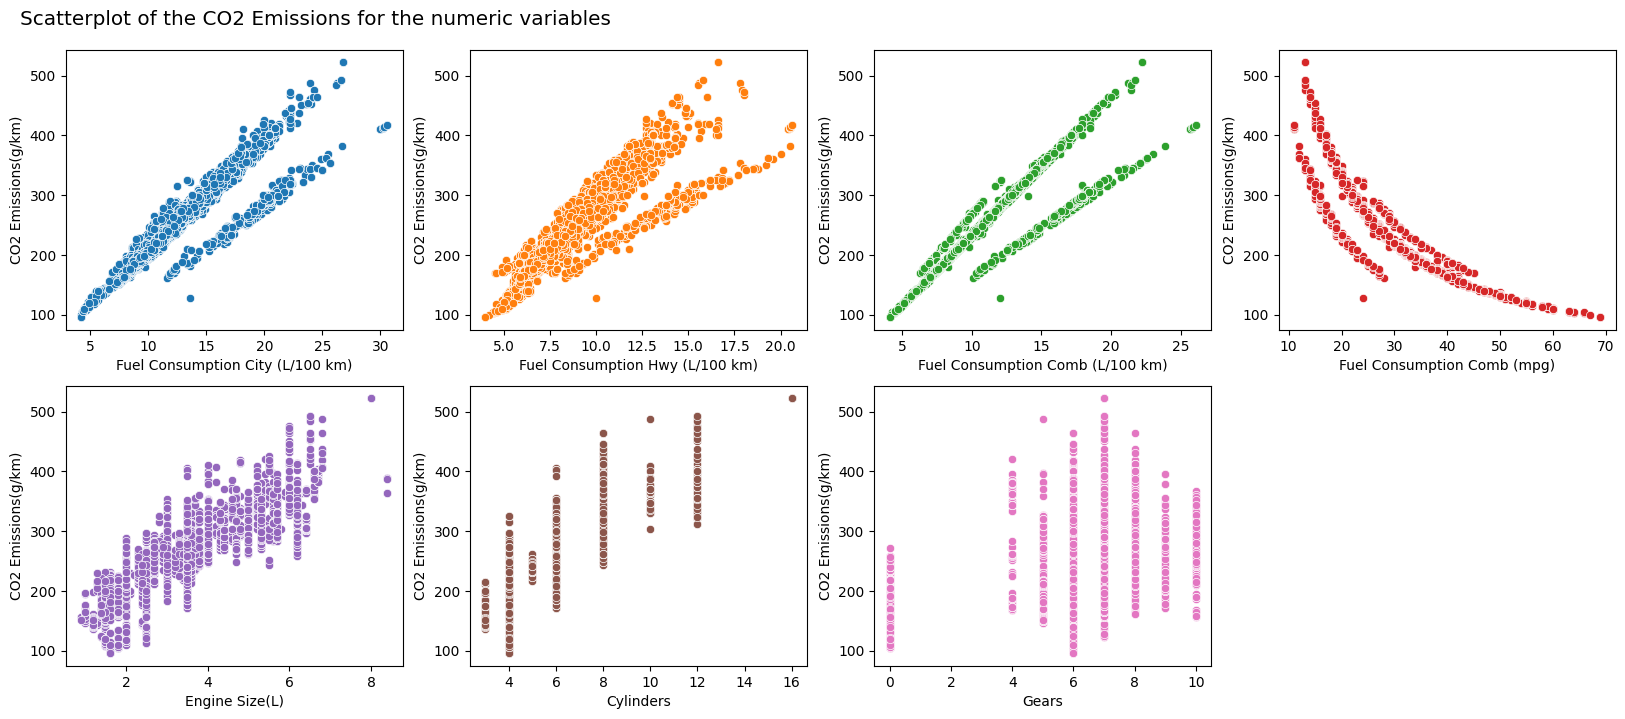

In [ ]:
fig=plt.figure(figsize=(20, 8))
fig.suptitle("Scatterplot of the CO2 Emissions for the numeric variables", x=0.25, y=0.93, fontsize = "x-large")
for i in range(len(numeric_variables)):
    plt.subplot(2, 4, i+1)
    sns.scatterplot(data=df_raw, x=numeric_variables[i], y=response_variable, color = num_color_palette[i])

- The following cell calculates the correlation coefficients of the predictor variables and plots them using the `heatmap()` function from `seaborn`. There are several variables with a very high correlation coefficient. As mentioned earlier, the combined consumption variables are redundant, as they are linearly related to city and highway consumption.





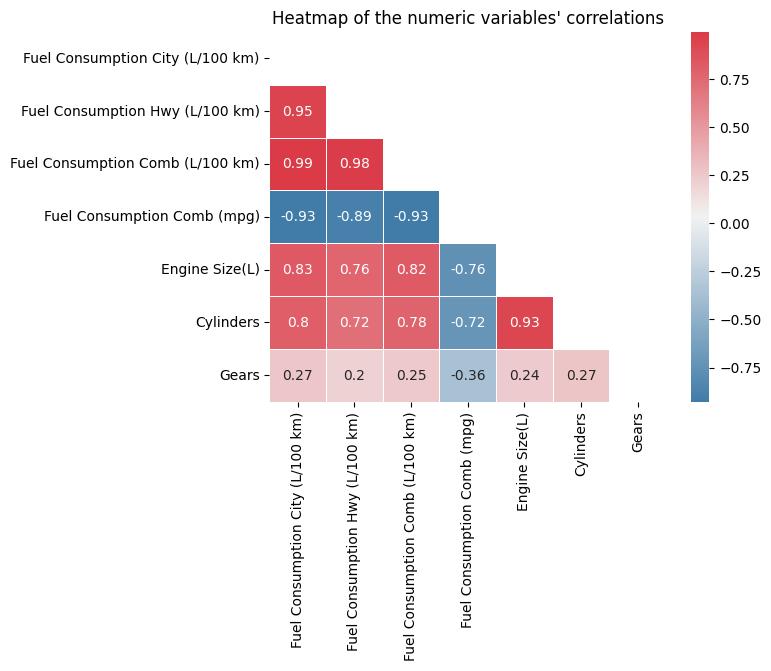

In [ ]:
corr = df_raw[numeric_variables].corr()

# The mask argument allows to represent only the values under the diagonal
sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)),
            annot=True, cmap=cor_color_palette,
            linewidths=.5).set_title("Heatmap of the numeric variables' correlations")
plt.show()

##Data Preparation (Second Iteration)
It’s time to preprocess the data with the information obtained from descriptive statistics. The operations to perform are as follows:
- Removal of duplicated observations and the single car that uses natural gas as fuel.
- Removal of redundant variables: We will remove the `Fuel Consumption Comb (mpg)` and `Fuel Consumption Comb (L/100 km)`, as they measure the same quantity in different units which, at the same time, is a linear combination of the `Fuel Consumption City (L/100 km)` and `Fuel Consumption Hwy (L/100 km)`.
- Identification of rows with `Make` and `Model`: Changing the identification of the rows from numbers to the concatenation of the manufacturing brand and model.
- Preprocessing to create ML models: this includes recoding categorical variables into numerical values and normalizing numerical variables so that models do not give more importance based on their range.



In [ ]:
# Removal of certain observations
is_duplicated = df_raw.duplicated()
uses_natural_gas = df_raw[categoric_variables[2]]=="N"
compound_codition = is_duplicated | uses_natural_gas
df_processed = df_raw.copy().loc[~compound_codition,]

# Identification of the rows
df_processed.index = df_processed["Make"]+" - "+df_processed["Model"]

# Removal of certain variables
df_processed = df_processed.drop(columns=["Fuel Consumption Comb (mpg)", "Fuel Consumption Comb (L/100 km)",
                                          "Make", "Model", "Vehicle Class"])
print("Dataset dimensions: "+str(df_raw.shape)+" -> "+str(df_processed.shape))

Dataset dimensions: (7385, 13) -> (6281, 8)


In [ ]:
# Define the features set and feature normalization
numeric_variables = ["Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)",
                     "Engine Size(L)", "Cylinders", "Gears"]
cars_df_nums = df_processed[numeric_variables]
df_processed[numeric_variables] = pd.DataFrame(StandardScaler().fit_transform(cars_df_nums),
                                                columns=cars_df_nums.columns, index=cars_df_nums.index)

# Recode the categorical variables to numerical values
df_processed[["Transmission","Fuel Type"]] = OrdinalEncoder().fit_transform(df_processed[["Transmission","Fuel Type"]])
df_processed.head()

,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),CO2 Emissions(g/km),Gears
ACURA - ILX,-0.850974,-0.876834,2.0,3.0,-0.762700,-1.040211,196,-0.903487
ACURA - ILX,-0.557975,-0.876834,4.0,3.0,-0.396803,-0.601399,221,-0.340399
ACURA - ILX HYBRID,-1.217224,-0.876834,3.0,3.0,-1.860389,-1.435142,136,0.222689
ACURA - MDX 4WD,0.247774,0.206446,2.0,3.0,0.025386,0.012939,255,-0.340399
ACURA - RDX AWD,0.247774,0.206446,2.0,3.0,-0.143490,-0.162586,244,-0.340399


## Conclusion
In this first part of the portfolio, we laid the groundwork for predicting CO2 emissions from a dataset of 7,385 Canadian vehicles by conducting a comprehensive analysis of the data through profiling, transformation, and visualization. The initial exploration revealed a diverse set of features—ranging from numerical predictors like fuel consumption and engine size to categorical variables such as vehicle class and fuel type—each contributing to the overall picture of vehicle emissions. Key findings from the exploratory data analysis include the strong positive relationship between fuel consumption metrics and CO2 emissions, the influence of engine characteristics (size and cylinders) on pollution levels, and the presence of outliers, such as the Bugatti Chiron, which highlight extreme cases within the dataset. Additionally, the identification of redundant variables (e.g., combined fuel consumption metrics) and duplicated observations underscored the importance of data cleaning to ensure model reliability.

The preprocessing steps undertaken—splitting the composite Transmission column, removing duplicates and the single natural gas vehicle, normalizing numerical features, and recoding categorical variables—have transformed the raw dataset into a refined form suitable for machine learning. These efforts reduced the dataset from 7,385 to 6,281 rows and streamlined the feature set, addressing issues like multicollinearity and high cardinality where appropriate. The visualizations, including scatterplots, boxplots, and a correlation heatmap, not only clarified these relationships but also provided actionable insights for feature selection in the next phase.

This notebook establishes a solid foundation for Part 2, where regression modeling will be employed to predict CO2 emissions based on the processed dataset. The patterns observed—such as the near-linear increase in emissions with fuel consumption and the variability across vehicle types—suggest that a well-tuned regression model could effectively capture these dynamics. Moving forward, we will explore various regression techniques, assess their performance, and potentially revisit decisions like the encoding of categorical variables or the handling of outliers to optimize predictive accuracy. Ultimately, this work demonstrates the critical role of data preparation and exploration in building robust predictive models, setting the stage for deeper insights into vehicle emissions and their contributing factors.

### Key Findings
- **Feature Relationships**: Fuel consumption (City/Highway) showed a strong positive correlation with CO2 emissions; engine size and cylinders also influenced emissions significantly.
- **Data Insights**: Identified outliers (e.g., Bugatti Chiron) and redundant variables (e.g., combined fuel consumption), highlighting the need for cleaning.
- **Preprocessing Impact**: Reduced dataset from 7,385 to 6,281 rows by removing duplicates and a natural gas vehicle. Furthermore, the features set was also modified by supressing redundant variables, recoding categorical ones and applying normalization.
- **Visualization Outcomes**: Scatterplots, boxplots, and correlation heatmaps clarified feature-emission relationships, guiding feature selection for modeling.

### Future Work
- Explore advanced feature selection to eliminate less predictive variables.
- Reassess outlier handling and categorical encoding (e.g., `Transmission`) to optimize model performance.
- Incorporate additional features (e.g., vehicle weight, driving conditions) to enhance predictive accuracy.
- Apply dimensionality reduction techniques (e.g., PCA) to manage high-cardinality categorical variables.